#  Определение паттернов номеров, наиболее вероятно относящихся к Flash Call, используемых при регистрации в приложении Viber

<a id="0."></a>
# Содержание: 
1. [Подготовка данных](#1.) 
<p></p>
2. [Анализ данных](#2.)  
 2.1. [Вызовы с одинаковой кодовой частью](#2.1.)  
 2.2. [Вызовы с одинаковым набором префикс-суффикс](#2.2.)  
 2.3. [Вызовы с одним префиксом и c суффиксами, образующими пул последовательных номеров](#2.3.)  
 2.4. [Наиболее вероятные кандидаты на шаблоны номеров, принадлежащие flash call сервисам](#2.4.)  
<p></p>
3. [Вывод](#3.)

<a id="1."></a> 
## 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math


Поменяю названия столбцов на более удобные:

In [2]:
data = pd.read_excel('viber.xlsx', sheet_name='data')
data.columns = ['anumber', 'cnt']


После первой попытки неудачной верификации, второй и последующие вызовы приходят уже с других номеров.  
Поэтому уберу строки с полем **cnt > 1**:

In [3]:
data = data.query('cnt == 1').reset_index(drop=True)


В дальнейшем буду называть ее ***оригинальной таблицей.***  

Добавлю три новых столбца, содержащих цифры из поля с полным номером А: **prefix**(цифры 1-4), **code**(цифры 5-10), **suffix**(цифры 11 и 12):

In [4]:
data['prefix'] = data['anumber'].apply(lambda x: int(str(x)[:4]))
data['code'] = data['anumber'].apply(lambda x: int(str(x)[4:10]))
data['suffix'] = data['anumber'].apply(lambda x: int(str(x)[10:]))
data.head()


,anumber,cnt,prefix,code,suffix
0,332412996289,1,3324,129962,89
1,332414582798,1,3324,145827,98
2,332414919598,1,3324,149195,98
3,332419111298,1,3324,191112,98
4,332420553298,1,3324,205532,98


[К содержанию](#0.) 
<a id="2."></a> 
## 2. Анализ данных

<a id="2.1."></a> 
### 2.1. Вызовы с одинаковой кодовой частью

**Предположение**: Новый пользователь сервиса с верификацией по flash call с первого раза ее не проходит, поэтому тот же код отправляется еще максимум 2 раза (итого максимум 3 раза перед 24-часовой блокировки пользователя)  
**Результат анализа**: Список сочетаний префикс-суффикс, которые замечены в звонках с повторяющимися кодами

Сгруппирую таблицу по кодам и посчитаю количество их появления:

In [5]:
codes_cnt = data.groupby('code')['anumber'].count().sort_values(ascending=False)
codes_cnt.head(10)


code
753815    3
407079    2
185274    2
725999    2
894583    2
598020    2
897976    2
763744    2
140728    2
763459    2
Name: anumber, dtype: int64

Имеются много кодов, которые отправлялись 2-3 раза. Это соответствует политике Viber - для каждого пользователя доступны 3 попытки верификации подряд. Затем бан на 24 часа.   
Список вызовов с кодовой частью, повторяющейся 2 или 3 раза в оригинальной таблице: 

In [6]:
#Набор кодов с повторениями
mfreq_codes = codes_cnt[(codes_cnt > 1) & (codes_cnt <= 3)]
#Записи вызовов с этими кодами:
data_same_code = data.query('code in @mfreq_codes.index').reset_index(drop=True)
data_same_code.head()


,anumber,cnt,prefix,code,suffix
0,332515394388,1,3325,153943,88
1,332592549379,1,3325,925493,79
2,332663914887,1,3326,639148,87
3,332775381559,1,3327,753815,59
4,332834733785,1,3328,347337,85


Оставлю только список уникальных сочетаний префикс-суффикс:

In [7]:
pref_suf_same_code = data_same_code.groupby(['prefix', 'suffix']).count().reset_index()[['prefix', 'suffix']]
pref_suf_same_code.head()


,prefix,suffix
0,3325,79
1,3325,88
2,3326,87
3,3327,59
4,3328,85


**Итог**:  
Получилось столько записей:

In [8]:
pref_suf_same_code.shape[0]


80

[К содержанию](#0.) 
<a id="2.2."></a> 
### 2.2. Вызовы с одинаковым набором префикс-суффикс

**Предположение**: Владелец сервиса с верификацией по flash call часто(или всегда) использует один и тот же номер_А, в который вставляет новый код.  
**Результат анализа**: Списки сочетаний префикс-суффикс, которые повторяются в выборке более 1-го раза

- сгруппирую данные по префиксу и суффиксу, 
- посчитаю число таких сочетаний,
- оставлю только сочетания с частотой > 1,
- отсортирую по убыванию числа повторений:

In [9]:
pref_suf_repeat_combins = (
    data.pivot_table(index=['prefix', 'suffix'], values='code', aggfunc='count')
    .query('code > 1').sort_values(by='code', ascending=False)
    .reset_index()[['prefix', 'suffix']]
)
pref_suf_repeat_combins.head()


,prefix,suffix
0,4978,1
1,3360,98
2,3324,89
3,4440,89
4,4967,3


**Итог**:  
Получилось столько записей:

In [10]:
pref_suf_repeat_combins.shape[0]


787

[К содержанию](#0.) 
<a id="2.3."></a> 
### 2.3. Вызовы с одним префиксом и c суффиксами, образующими пул последовательных номеров

**Предположение**: Владелец сервиса с верификацией по flash call звонит с номеров, которые являются частью одного пула.  
**Результат анализа**: Списки сочетаний префикс-суффикс, которые можно отнести к одному пулу номеров.  
Например: 3324-ХХХХХХ-10, 3324-ХХХХХХ-11, ... 3324-ХХХХХХ-19  


Для каждого уникального сочетания посчитаю ранг - число соседних номеров, с которыми есть совпадения по префиксу, а суффиксы образуют непрерываемый пул. Буду проверять 2 соседних номера вверх и вниз по списку от рассматриваемого номера.

Оставлю уникальные сочетания суффикс-префикс и отсортирую их по возрастанию:

In [11]:
#data = data.sort_values(by=['prefix', 'suffix']).reset_index(drop=True)
uniq_suf_pref = (
    data.pivot_table(index=['prefix', 'suffix'])
    .reset_index()[['prefix', 'suffix']]
    .sort_values(['prefix', 'suffix'])
)
uniq_suf_pref.head()


,prefix,suffix
0,3324,89
1,3324,98
2,3325,79
3,3325,88
4,3325,97


Функция рассчитывает сам ранг:

In [12]:
def calc_rank(index, prev_num, fwd_num, data):
    prefix = data['prefix']
    suffix = data['suffix']
    rank = 0
    for i in range(1, prev_num + 1):
        # Если текущий и предыдущий префиксы равны:
        if prefix[index] == prefix[index - i]:
            # Если разница между суффиксами равна i
            if suffix[index] - suffix[index - i] == i:
                rank += 1
    for i in range(1, fwd_num + 1):
        # Если текущий и последующий префиксы равны:
        if prefix[index] == prefix[index + i]:
            # Если разница между суффиксами равна i
            if suffix[index + i] - suffix[index] == i:
                rank += 1
    return rank
        

Эта функция считает, сколько соседей снизу и сверху имеет рассматриваемый номер:

In [13]:
def calc_prev_fwd_nums(index, last_index):
    prev_num = int(round(4*index / (2*index + 1)))
    fwd_num = int(round(4*(last_index - index) / (2*(last_index - index) + 1)))
    return prev_num, fwd_num


Это основная функция, из которой вызываются функции, описанные ранее:

In [14]:
def get_rank(row, last_index, data):
    # Индекс строки в таблице:
    index = row.name
    # Сколько позиций назад и вперед от текщего индекса брать для сравнения
    prev_num, fwd_num = calc_prev_fwd_nums(index, last_index)
    # Считаем количество соседей из того же пула:
    rank = calc_rank(index, prev_num, fwd_num, data)
    return rank
    

Создам столбец с рангами:

In [15]:
uniq_suf_pref['rank'] = uniq_suf_pref.apply(get_rank, axis=1, args=[len(data)-1, data])
uniq_suf_pref.head()


,prefix,suffix,rank
0,3324,89,0
1,3324,98,0
2,3325,79,0
3,3325,88,0
4,3325,97,0


Такие ранги найдены:

In [16]:
uniq_suf_pref['rank'].value_counts()

0    1113
Name: rank, dtype: int64

**Итог**:  
Ни одно из сочетаний префикс-суффикс не является частью непрерывного пула.  
Данное исследование оставлю в анализе - как полезное для будущих расчетов.

[К содержанию](#0.) 
<a id="2.4."></a> 
### 2.4. Наиболее вероятные кандидаты на шаблоны номеров, принадлежащие flash call сервисам

Т.к. результат получен только для п.п. 2.2. и 2.3., то искомыми кандидатами буду считать сочетания суффикс-префикс, имеющиеся в итоговых таблицах только из этих пунктов(одновременно):

In [17]:
goal_pref_suf = (
    pref_suf_same_code.merge(pref_suf_repeat_combins, on=['prefix', 'suffix'])
    .sort_values(by=['prefix', 'suffix'])
)
print('Итого сочетаний:', goal_pref_suf.shape[0])


Итого сочетаний: 76


Схематично отображу распределение полученных шаблонов:

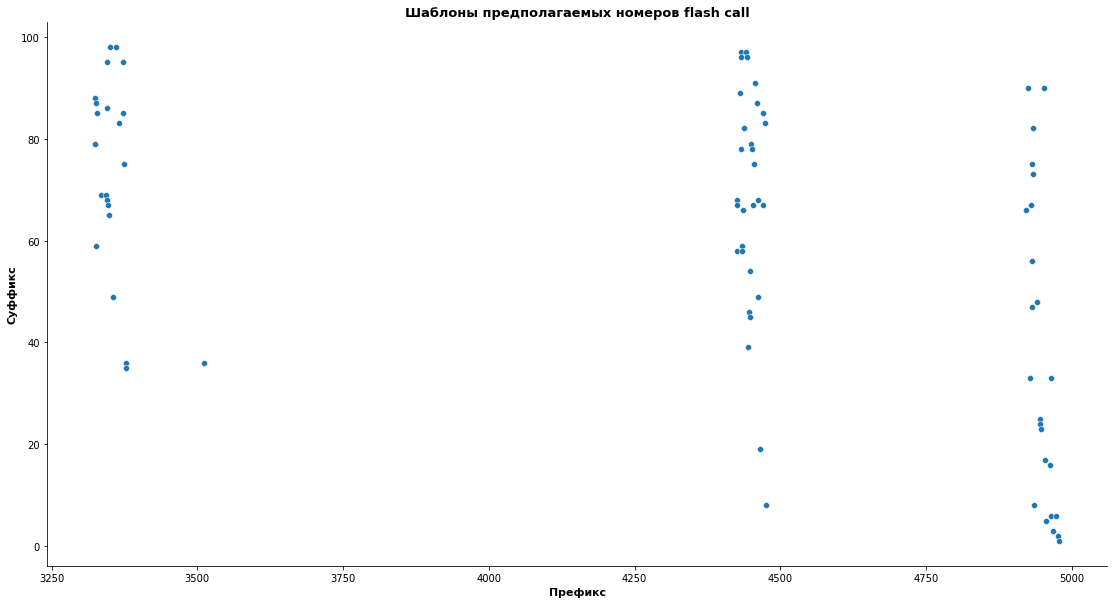

In [18]:
plt.figure(figsize=(19,10))
ax = sns.scatterplot(data=goal_pref_suf, x='prefix', y='suffix')
ax.set_title('Шаблоны предполагаемых номеров flash call',
                 fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax.set_xlabel('Префикс', fontdict={'fontsize': 11, 'fontweight': 'bold'})
ax.set_ylabel('Суффикс', fontdict={'fontsize': 11, 'fontweight': 'bold'})
sns.despine()


[К содержанию](#0.) 
<a id="3."></a> 
## 3. Вывод

1. Найдены подозрительные шаблоны в двух группах анализа:
 - Вызовы с одинаковой кодовой частью
 - Вызовы с одинаковым набором префикс-суффикс(префикс любой)
2. В итоге получена таблица из 76-ти шаблонов, которые присутствуют одновременно в обеих группах.
3. Найденные шаблоны схематично отображены на диаграмме